# Carregando os dados

In [1]:
import pandas as pd
import datetime
import requests
import sqlite3
import os
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pprint
import unidecode
import urllib
import mysql.connector as db

# Carregando dados Spotify

In [2]:
HERE = os.getcwd()
user_data_path = os.path.join(HERE, 'user_data')
users = os.listdir(user_data_path)

In [3]:
dfs = []

for user in users:
    # lista com todos os .json naquele path
    history_files = glob.glob(os.path.join(user_data_path, user, '*.json'))
    for f in history_files:
        partial_df = pd.read_json(f)
        partial_df['user'] = user
        dfs.append(partial_df.copy())

df = pd.concat(dfs, ignore_index=True)

In [4]:
# Remove linhas duplicadas pq tem overlap nos json de historico
df = df.loc[~df.duplicated()]

In [5]:
df.loc[:,'endTime'] = pd.to_datetime(df['endTime'])

# Pegando API para algum BD de Música

In [6]:
# LAST FM KEY
key = 'f34cb13d72cd172648a03f092f6a2f85'

In [7]:
url = f"http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key={key}&artist=Blue Öyster Cult&track=(Don't Fear) The Reaper&autocorrect=1&format=json"

In [8]:
album_url = f'http://ws.audioscrobbler.com/2.0/?method=album.getinfo&api_key={key}&mbid=9290923d-3b97-45ab-aac1-4880980c72ed&format=json'

In [9]:
r_album = requests.get(album_url)
r_song = requests.get(url)
j_album = r_album.json()
j_song = r_song.json()

In [10]:
pprint.pprint(j_album)

             'returned to the chart at number 189 on 12 '
                               'December of that year for its 742nd charting '
                               'week. It has continued to sporadically appear '
                               'on the Billboard 200 since then, reaching 900 '
                               'weeks on the chart in April 2015.\n'
                               '\n'
                               '"The combination of words and music hit a '
                               'peak," explained Gilmour. "All the music '
                               'before had not had any great lyrical point to '
                               'it. And this one was clear and concise. The '
                               "cover was also right. I think it's become like "
                               'a benevolent noose hanging behind us. '
                               'Throughout our entire career, people have said '
                               'we would never top the 

In [11]:
pprint.pprint(j_song)

{'track': {'album': {'@attr': {'position': '3'},
                     'artist': 'Blue Öyster Cult',
                     'image': [{'#text': 'https://lastfm.freetls.fastly.net/i/u/34s/b785009dbb0e6ce488d0a8f74d313f31.png',
                                'size': 'small'},
                               {'#text': 'https://lastfm.freetls.fastly.net/i/u/64s/b785009dbb0e6ce488d0a8f74d313f31.png',
                                'size': 'medium'},
                               {'#text': 'https://lastfm.freetls.fastly.net/i/u/174s/b785009dbb0e6ce488d0a8f74d313f31.png',
                                'size': 'large'},
                               {'#text': 'https://lastfm.freetls.fastly.net/i/u/300x300/b785009dbb0e6ce488d0a8f74d313f31.png',
                                'size': 'extralarge'}],
                     'mbid': '4e498ca7-a8f3-342a-b782-8194eefb6da1',
                     'title': 'Agents of Fortune',
                     'url': 'https://www.last.fm/music/Blue+%C3%96yster+Cult

# Database com SQLite

## Conectando no DB

In [12]:
conn = db.connect(
    host="localhost",
    user="root",
    passwd="7622446",
    database="music_db"
)
cursor = conn.cursor(buffered=True)


def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

## Criando o DB

In [13]:
artists_sql = """
CREATE TABLE IF NOT EXISTS artists
  (
  id INT AUTO_INCREMENT,
  mbid VARCHAR(255) NOT NULL UNIQUE,
  name VARCHAR(255) NOT NULL,
  PRIMARY KEY(id)
  )
"""

In [14]:
create_table(conn, artists_sql)

In [15]:
albums_sql = """
CREATE TABLE IF NOT EXISTS albums(
    id INT AUTO_INCREMENT,
    mbid VARCHAR(255) NOT NULL UNIQUE,
    name VARCHAR(255) NOT NULL,
    artist_mbid VARCHAR(255) NOT NULL,
    PRIMARY KEY(id),
    FOREIGN KEY(artist_mbid)
      REFERENCES artists(mbid)
        ON DELETE CASCADE
        ON UPDATE CASCADE
);
"""

In [16]:
create_table(conn, albums_sql)

In [17]:
tracks_sql = """
CREATE TABLE IF NOT EXISTS tracks(
    id INT AUTO_INCREMENT,
    mbid VARCHAR(255) NOT NULL UNIQUE,
    name VARCHAR(255) NOT NULL,
    artist_mbid VARCHAR(255) NOT NULL,
    album_mbid VARCHAR(255) NULL,
    listeners INTEGER NULL,
    duration INTEGER NULL,
    playcount INTEGER NULL,
    updated_on DATE NULL,
    date_published VARCHAR(255) NULL,
    PRIMARY KEY(id),
    FOREIGN KEY(artist_mbid)
      REFERENCES artists(mbid)
        ON DELETE CASCADE
        ON UPDATE CASCADE,
    FOREIGN KEY(album_mbid)
      REFERENCES albums(mbid)
        ON DELETE CASCADE
        ON UPDATE CASCADE
);
"""


In [18]:
create_table(conn, tracks_sql)

In [19]:
tags_sql = """
CREATE TABLE IF NOT EXISTS tags(
    id INT AUTO_INCREMENT,
    tag_name VARCHAR(255) UNIQUE,
    PRIMARY KEY(id)
    );
"""

In [20]:
create_table(conn, tags_sql)

In [21]:
# Guarda só a tag mais comum da track
top_track_tags_sql = """
CREATE TABLE IF NOT EXISTS top_track_tags(
    id INT AUTO_INCREMENT,
    track_mbid VARCHAR(255) UNIQUE,
    tag_id INTEGER,
    PRIMARY KEY (id, track_mbid, tag_id),
    FOREIGN KEY(track_mbid)
      REFERENCES tracks(mbid)
        ON DELETE CASCADE
        ON UPDATE CASCADE,
    FOREIGN KEY(tag_id)
      REFERENCES tags(id)
        ON DELETE CASCADE
        ON UPDATE CASCADE
);
"""

In [22]:
create_table(conn, top_track_tags_sql)

In [23]:
track_tags_sql = """
CREATE TABLE IF NOT EXISTS track_tags(
    id INT AUTO_INCREMENT,
    track_mbid VARCHAR(255),
    tag_id INTEGER,
    PRIMARY KEY (id, track_mbid, tag_id),
    FOREIGN KEY(track_mbid)
      REFERENCES tracks(mbid)
        ON DELETE CASCADE
        ON UPDATE CASCADE,
    FOREIGN KEY(tag_id)
      REFERENCES tags(id)
        ON DELETE CASCADE
        ON UPDATE CASCADE
);
"""

In [24]:
create_table(conn, track_tags_sql)

In [25]:
users_sql = """
CREATE TABLE IF NOT EXISTS users(
    id INT AUTO_INCREMENT,    
    user VARCHAR(255) UNIQUE,
    PRIMARY KEY(id)
);
"""

In [26]:
create_table(conn, users_sql)

In [27]:
user_data_sql = """
CREATE TABLE IF NOT EXISTS user_data(
    id INT AUTO_INCREMENT,  
    user_id INTEGER,
    end_time DATETIME,
    artist_name VARCHAR(255),
    track_name VARCHAR(255),
    ms_played INTEGER,
    PRIMARY KEY(id),
    UNIQUE(user_id, end_Time, artist_name, track_name, ms_played),
    FOREIGN KEY(user_id)
      REFERENCES users(id)
        ON DELETE CASCADE
        ON UPDATE CASCADE
);
"""

In [28]:
create_table(conn, user_data_sql)

In [29]:
cursor.execute("SHOW tables")
cursor.fetchall()

[('albums',),
 ('artists',),
 ('tags',),
 ('top_track_tags',),
 ('track_tags',),
 ('tracks',),
 ('user_data',),
 ('users',)]

In [30]:
conn.commit()

# Preenchendo o DB com o API + dados spotify

In [31]:
df

,endTime,artistName,trackName,msPlayed,user
0,2019-07-26 20:54:00,Iron Maiden,Fear Of The Dark - 1998 Remastered Version,290564,mateus
1,2019-07-26 22:34:00,Pink Floyd,Is There Anybody Out There?,23150,mateus
2,2019-07-27 13:17:00,Stevie Ray Vaughan,Lenny,41820,mateus
3,2019-07-27 13:29:00,Stevie Ray Vaughan,Lenny,354160,mateus
4,2019-07-27 13:34:00,Stevie Ray Vaughan,Lenny,297160,mateus
...,...,...,...,...,...
149980,2020-01-16 00:18:00,Buckethead,Soothsayer (Dedicated to Aunt Suzie),544800,test_user
149981,2020-01-16 00:25:00,Iron Maiden,Afraid to Shoot Strangers - 2015 Remaster,416560,test_user
149982,2020-01-16 00:31:00,Lynyrd Skynyrd,Simple Man,357933,test_user
149983,2020-01-16 00:34:00,The Allman Brothers Band,Midnight Rider,180066,test_user


In [32]:
def execute_insert_sql(conn, sql_str, vals):
    try:
        c = conn.cursor()
        c.execute(sql_str, vals)
        return c.lastrowid
    except Error as e:
        print(e)


def execute_fetch_all(conn, sql_str):
    try:
        c = conn.cursor()
        c.execute(sql_str)
        all = c.fetchall()
        return all
    except Error as e:
        print(e)

  
def execute_fetch_one(conn, sql_str, vals):
    try:
        c = conn.cursor()
        c.execute(sql_str, vals)
        result = c.fetchone()
        if result:
          return result
        else:
          return None
    except Error as e:
        print(e)

## Preenchendo com os dados do Spotify

In [33]:
for user in df['user'].unique():
    insert_user_sql = "INSERT IGNORE INTO users (user) VALUES (%s)"
    user_vals = (user,)
    _ = execute_insert_sql(conn, insert_user_sql, user_vals)
    user_id = execute_fetch_one(conn, "SELECT id FROM users WHERE user=%s", (user,))[0]
    add_data = df.loc[df['user'] == user]
    #existing_data = pd.read_sql(f"SELECT * FROM user_data WHERE user_id={user_id}", con=conn)

    for index, row in add_data.iterrows():
        # Pega o dado do df
        end_time = row['endTime'].strftime('%Y-%m-%d %H:%M:%S')
        artist_name = row['artistName']
        track_name = row['trackName']
        ms_played = row['msPlayed']
        # cria o sql insert stamtement
        insert_spotify_data_sql = "INSERT IGNORE INTO user_data (user_id, end_time, artist_name, track_name, ms_played) VALUES (%s,%s,%s,%s,%s)"
        vals = (user_id, end_time, artist_name, track_name, ms_played)
        execute_insert_sql(conn, insert_spotify_data_sql, vals)

In [34]:
conn.commit()

## Preenchendo o database das musicas a partir do API

### Musicas Remasters e Lives

Lidando com o problema de musicas serem LIVE ou Remaster, o que dai complica na hora de ter a informacao da musica

In [35]:
# Tuplas de (artista, musica)
unique_tracks = execute_fetch_all(conn, "SELECT DISTINCT artist_name, track_name FROM user_data;")

In [36]:
remasters = [track for artist, track in unique_tracks if 'Remaster' in track]
remasters[0:5]

['Fear Of The Dark - 1998 Remastered Version',
 'Another One Bites The Dust - Remastered 2011',
 'Here I Go Again - 2018 Remaster',
 'When the Levee Breaks - 2012 Remaster',
 'Hot for Teacher - 2015 Remaster']

In [37]:
lives = [track for artist, track in unique_tracks if 'Live' in track]

In [38]:
lives[0:5]

['While My Guitar Gently Weeps - Live From Madison Square Garden, New York, U.S.A, 1971 / 2009 Mix',
 'Like A Rolling Stone - Live At Monterey',
 'Crossroads - Live',
 'Layla - Acoustic; Live at MTV Unplugged, Bray Film Studios, Windsor, England, UK, 1/16/1992; 1999 Remaster',
 'Long Live Rock N Roll']

In [39]:
slashes = [track for artist, track in unique_tracks if '-' in track]

In [40]:
slashes[0:5]

['Fear Of The Dark - 1998 Remastered Version',
 'Another One Bites The Dust - Remastered 2011',
 'Here I Go Again - 2018 Remaster',
 'When the Levee Breaks - 2012 Remaster',
 'Hot for Teacher - 2015 Remaster']

In [41]:
# O jeito mais facil de lidar é dar split em ' - ' (espaço slash espaço) e pegar o primeiro termo. Muito pouco provavel que tenha um slah com dois espaços no nome da musica.
# Exemplo
example_track1 = 'Bron-Y-Aur Stomp - Remaster'
example_track2 = 'Time'
print(example_track1.split(' - ')[0])
print(example_track2.split(' - ')[0])


Bron-Y-Aur Stomp
Time


### Funcoes auxiliares

In [42]:
def make_request(url):
  r = requests.get(url)
  j = r.json()
  return j

def unpack_track_info(j):
  try:
    artist_mbid = j['track']['artist']['mbid']
  except KeyError:
    artist_mbid = None

  try:
    track_mbid = j['track']['mbid']
  except KeyError:
    track_mbid = None

  try:
    album_name = j['track']['album']['title']
  except KeyError:
    album_name = None

  try:
    album_mbid = j['track']['album']['mbid']
  except KeyError:
    album_mbid = None

  try:
    listeners = int(j['track']['listeners'])
  except KeyError:
    listeners = None

  try:
    playcount = j['track']['playcount']
  except KeyError:
    playcount = None

  try:
    duration = j['track']['duration']
  except KeyError:
    duration = None

  try:
    published_on = j['track']['wiki']['published']
  except KeyError:
    published_on = None

  try:
    tags = [tag['name'] for tag in j['track']['toptags']['tag']]
  except KeyError:
    tags = None

  date_updated = str(datetime.datetime.today().date())

  return track_mbid, artist_mbid, album_mbid, album_name, listeners, duration, playcount, date_updated, published_on, tags

### Rodando para tudo

In [43]:
# Tuplas de (artista, musica)
unique_tracks = execute_fetch_all(conn, "SELECT DISTINCT artist_name, track_name FROM user_data;")

In [44]:
len(unique_tracks)

4807

In [45]:
import time

In [46]:
# TODO: VAi ter problema de quando a pesquisa nao retorna um artist_mbid e tal
# TODO: ACho que a solucao final vai ser criar um id para artistsas que nao aparecerem no banco de spotify, se for um numero apreciavel
maxlen = len(unique_tracks)
counter = 0
for artist, song in unique_tracks:
  time.sleep(0.5)
  # TODO: Adicionar um contador aqui, talvez tqdm?
  ### OBTENDO INFO DA MUSICA
  print(f"Adicionando: {counter+1}/{maxlen}")
  counter += 1
  try:
    # Esses song_to_req e artist_to_req são só pra mandar no url de request
    # Para fazer o request eu quero remover os LIVE ou REMASTER do nome da musica, que sempre sao separados por ' - '
    if " - " in song:
      song_to_req = song.split('-')[-1].strip()
    else:
      song_to_req = song
    #song_to_req = song.split(' - ')[0]
    # Substitui o espaço por '+' pra entrar no URL
    song_to_req = song_to_req.replace(' ', '+')
    artist_to_req = artist.replace(' ', '+')
    song_info_url = f'http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key={key}&artist={artist_to_req}&track={song_to_req}&autocorrect=1&format=json'
    j = make_request(song_info_url)
    track_mbid, artist_mbid, album_mbid, album_name, listeners, duration, playcount, updated_on, date_published, tags = unpack_track_info(j)
  except Exception as e:
    print(artist, song)
    print(e)
    continue

  ### ADICIONANDO AO BD
  ## Artista
  # Se foi encontrado o artista no last.fm
  if artist_mbid:
    artist_check_sql = "SELECT id FROM artists WHERE mbid=%s"
    artist_vals = (artist_mbid,)
    artist_check_result = execute_fetch_one(conn, artist_check_sql, artist_vals)
    # Caso o artista ainda nao exista, adiciono a info
    if not artist_check_result:
      insert_artist_data_sql = "INSERT IGNORE INTO artists (mbid, name) VALUES (%s,%s)"
      # Eu aqui adiciono o 'mbid' do last.fm e o 'artist' que vem do spotify. Coloco o nome diretamente do spotify, se ocorre alguma correcao no last.fm eu ignoro
      artist_vals = (artist_mbid, artist)
      execute_insert_sql(conn, insert_artist_data_sql, artist_vals)


  ## Albums
  # Aqui só to criando um banco de album/album_id/artista. Ainda nao to linkando que musica que é de qual album. Nao sei como vou fazer isso ainda
  if album_name and album_mbid and artist_mbid:
    album_check_sql = "SELECT id FROM albums WHERE mbid=%s"
    album_vals = (album_mbid,)
    album_check_result = execute_fetch_one(conn, album_check_sql, album_vals)
    # Caso o album ainda nao exista, adiciono a info
    if not album_check_result:
      insert_album_data_sql = "INSERT IGNORE INTO albums (mbid, name, artist_mbid) VALUES (%s,%s,%s)"
      album_vals = (album_mbid, album_name, artist_mbid)
      execute_insert_sql(conn, insert_album_data_sql, album_vals)

  ## Tracks
  # Aqui só necessito que tenha track_mbid e artist_mbid. Artist_name e track_name sempre vai ter
  if track_mbid and artist_mbid:
    track_check_sql = "SELECT id FROM tracks WHERE mbid=%s"
    track_vals = (track_mbid,)
    track_check_result = execute_fetch_one(conn, track_check_sql, track_vals)
    # Se nao existe ainda a musica
    if not track_check_result:
      insert_track_data_sql = "INSERT IGNORE INTO tracks (mbid, name, artist_mbid, album_mbid, listeners, duration, playcount, updated_on, date_published) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)"
      # Eu aqui adiciono o 'mbid' do last.fm e o 'artist' que vem do spotify. Coloco o nome diretamente do spotify, se ocorre alguma correcao no last.fm eu ignoro
      track_vals = (track_mbid, song, artist_mbid, album_mbid, listeners, duration, playcount, updated_on, date_published)
      execute_insert_sql(conn, insert_track_data_sql, track_vals)

  ## Tags
  # Tem que ver aqui, acredito que se nao tenha tag (ou tenha só 1) o api retorne uma lista vazia []. Se nao for preciso mudar isso.
  if tags:
    for tag in tags:
      # Confere se a tag já existe
      tag_check_sql = "SELECT id, tag_name FROM tags WHERE tag_name=%s"
      tag_vals = (tag,)
      tag_check_result = execute_fetch_one(conn, tag_check_sql, tag_vals)
      # Se já existe a tag, só guarda qual id ela tem
      if tag_check_result:
        tag_id = tag_check_result[0]
      # Caso nao exista, adiciona a tag e pega o id
      else:
        insert_tag_data_sql = "INSERT IGNORE INTO tags (tag_name) VALUES (%s)"
        # tag vals ja definido
        tag_id = execute_insert_sql(conn, insert_tag_data_sql, tag_vals)
      ## Track Tags
      # Caso tenha track_mbid só
      if track_mbid:
        # Confere se o par track/tag ja existem em track_tags
        track_tag_check_sql = "SELECT track_mbid, tag_id FROM track_tags WHERE track_mbid=%s AND tag_id=%s"
        track_tag_vals = (track_mbid, tag_id)
        track_tag_check_result = execute_fetch_one(conn, track_tag_check_sql, track_tag_vals)
        if not track_tag_check_result:
          insert_track_tag_data_sql = "INSERT IGNORE INTO track_tags (track_mbid, tag_id) VALUES (%s,%s)"
          track_tag_vals = (track_mbid, tag_id)
          execute_insert_sql(conn, insert_track_tag_data_sql, track_tag_vals)
        # Confere se a tag é a primeira da lista tags. Se for, ela é a 'top-tag' do track.
        if tag == tags[0]:
          # Confere se o par track/tag ja existem em top_track_tags
          top_track_tag_check_sql = "SELECT track_mbid, tag_id FROM top_track_tags WHERE track_mbid=%s AND tag_id=%s"
          top_track_tag_vals = (track_mbid, tag_id)
          top_track_tag_check_result = execute_fetch_one(conn, top_track_tag_check_sql, top_track_tag_vals)
          if not top_track_tag_check_result:
            insert_top_track_tag_data_sql = "INSERT IGNORE INTO top_track_tags (track_mbid, tag_id) VALUES (%s,%s)"
            top_track_tag_vals = (track_mbid, tag_id)
            execute_insert_sql(conn, insert_top_track_tag_data_sql, top_track_tag_vals)

conn.commit()

o: 3938/4807
Adicionando: 3939/4807
Adicionando: 3940/4807
Adicionando: 3941/4807
Adicionando: 3942/4807
Adicionando: 3943/4807
Adicionando: 3944/4807
Adicionando: 3945/4807
Adicionando: 3946/4807
Adicionando: 3947/4807
Adicionando: 3948/4807
Adicionando: 3949/4807
Adicionando: 3950/4807
Adicionando: 3951/4807
Adicionando: 3952/4807
Adicionando: 3953/4807
Adicionando: 3954/4807
Adicionando: 3955/4807
Adicionando: 3956/4807
Adicionando: 3957/4807
Adicionando: 3958/4807
Adicionando: 3959/4807
Adicionando: 3960/4807
Adicionando: 3961/4807
Adicionando: 3962/4807
Adicionando: 3963/4807
Adicionando: 3964/4807
Adicionando: 3965/4807
Adicionando: 3966/4807
Adicionando: 3967/4807
Adicionando: 3968/4807
Adicionando: 3969/4807
Adicionando: 3970/4807
Adicionando: 3971/4807
Adicionando: 3972/4807
Adicionando: 3973/4807
Adicionando: 3974/4807
Adicionando: 3975/4807
Adicionando: 3976/4807
Adicionando: 3977/4807
Adicionando: 3978/4807
Adicionando: 3979/4807
Adicionando: 3980/4807
Adicionando: 3981/480

## Testando o bd

In [55]:
tracks_df = pd.read_sql("SELECT * FROM tracks;", con=conn)
albums_df = pd.read_sql("SELECT * FROM albums;", con=conn)
artists_df = pd.read_sql("SELECT * FROM artists;", con=conn)
tags_df = pd.read_sql("SELECT * FROM tags;", con=conn)
track_tags_df = pd.read_sql("SELECT * FROM track_tags;", con=conn)
top_track_tags_df = pd.read_sql("SELECT * FROM top_track_tags;", con=conn)
user_data_df = pd.read_sql("SELECT * FROM user_data", con=conn)

In [56]:
tracks_df

,mbid,name,artist_mbid,album_mbid,listeners,duration,playcount,updated_on,date_published
0,1cf70497-fe02-4d06-8f88-ee8a5a00424a,Fear Of The Dark - 1998 Remastered Version,ca891d65-d9b0-4258-89f7-e6ba29d83767,b0b6f83c-8d1a-3e5f-aa26-e6c56324e393,469008,460000,3677045,2021-05-23,"15 Mar 2009, 17:44"
1,36918e84-7ea8-4308-8cad-ae6d75a895c8,Is There Anybody Out There?,83d91898-7763-47d7-b03b-b92132375c47,d4611812-e7cd-42bf-885a-b1cea9fd52bc,375009,160000,2089735,2021-05-23,"17 Jan 2017, 07:46"
2,579b0b7d-bc5d-4ce0-afe5-cb8c43a08615,Lenny,f5426431-f490-4678-ad44-a75c71097bb4,bdd2c406-5599-4945-81fa-f74ec5e43940,121952,297000,390116,2021-05-23,"14 May 2009, 12:55"
3,966b4cc8-f549-4a3f-b675-555829abc8d1,Angie,b071f9fa-14b0-4217-8e97-eb41da73f598,c35dcc77-46dc-4b98-8030-640b4f898d87,699097,271000,3631147,2021-05-23,"31 Aug 2009, 19:42"
4,7e72b6fc-30c8-4bcb-a221-a12a24ca3804,Sultans Of Swing,614e3804-7d34-41ba-857f-811bad7c2b7a,e5e717df-5dc3-36f9-adbd-fff1b4aa2cef,1171823,653000,8912212,2021-05-23,"05 Jun 2008, 17:13"
...,...,...,...,...,...,...,...,...,...
1728,8aac5aba-8a6d-4472-9eb8-2bffdd793634,Stepping Stone,06fb1c8b-566e-4cb2-985b-b467c90781d4,bc0005f1-e3db-4104-a0a1-3ef84c85a857,77628,252000,231597,2021-05-23,None
1729,3115d85d-5892-4522-b9ea-d901661fd2ba,Angel,06fb1c8b-566e-4cb2-985b-b467c90781d4,6ab98585-ecbf-4ecd-a9d6-cfeb96076738,339798,265000,1182229,2021-05-23,"04 Apr 2010, 16:20"
1730,447cec5c-bc69-4a26-8712-3d104c02a3ce,Drifting,06fb1c8b-566e-4cb2-985b-b467c90781d4,bc0005f1-e3db-4104-a0a1-3ef84c85a857,73921,228000,231160,2021-05-23,None
1731,a0a009c9-8f91-4da4-a695-f63ca49946a8,"Power of Soul - Live at the Fillmore East, NY ...",06fb1c8b-566e-4cb2-985b-b467c90781d4,d7746cf0-4d22-45a0-8f92-dc8caf427119,40995,415000,118844,2021-05-23,None


In [57]:
albums_df

,mbid,name,artist_mbid
0,b0b6f83c-8d1a-3e5f-aa26-e6c56324e393,Fear of the Dark,ca891d65-d9b0-4258-89f7-e6ba29d83767
1,d4611812-e7cd-42bf-885a-b1cea9fd52bc,The Wall,83d91898-7763-47d7-b03b-b92132375c47
2,bdd2c406-5599-4945-81fa-f74ec5e43940,The Slow Blues,f5426431-f490-4678-ad44-a75c71097bb4
3,c35dcc77-46dc-4b98-8030-640b4f898d87,Goats Head Soup,b071f9fa-14b0-4217-8e97-eb41da73f598
4,e5e717df-5dc3-36f9-adbd-fff1b4aa2cef,Dire Straits,614e3804-7d34-41ba-857f-811bad7c2b7a
...,...,...,...
991,39038bd7-ef15-4224-b994-7784f11c1b3a,Duke,c5725831-2596-48f1-8f1c-ebe237362860
992,057056b0-7431-467b-b711-f850c8483c90,Platinum Collection,c5725831-2596-48f1-8f1c-ebe237362860
993,d7876fcb-c629-4b17-b973-de9824279360,Selling England by the Pound,c5725831-2596-48f1-8f1c-ebe237362860
994,97e87131-86ec-3588-8eb4-1453ed4ee379,Hendrix In The West,06fb1c8b-566e-4cb2-985b-b467c90781d4


In [58]:
artists_df

,mbid,name
0,ca891d65-d9b0-4258-89f7-e6ba29d83767,Iron Maiden
1,83d91898-7763-47d7-b03b-b92132375c47,Pink Floyd
2,f5426431-f490-4678-ad44-a75c71097bb4,Stevie Ray Vaughan
3,b071f9fa-14b0-4217-8e97-eb41da73f598,The Rolling Stones
4,614e3804-7d34-41ba-857f-811bad7c2b7a,Dire Straits
...,...,...
661,ba0e7638-0cd6-4ff4-8987-c3e224d22c23,Kygo
662,b3998c06-04e6-4b1d-bd2a-d5b83572ae7b,Maria Bethânia
663,7c7f9c94-dee8-4903-892b-6cf44652e2de,Tears For Fears
664,c5725831-2596-48f1-8f1c-ebe237362860,Genesis


In [59]:
top_track_tags_df

,track_mbid,tag_id
0,1cf70497-fe02-4d06-8f88-ee8a5a00424a,1
1,36918e84-7ea8-4308-8cad-ae6d75a895c8,6
2,579b0b7d-bc5d-4ce0-afe5-cb8c43a08615,10
3,966b4cc8-f549-4a3f-b675-555829abc8d1,7
4,7e72b6fc-30c8-4bcb-a221-a12a24ca3804,7
...,...,...
1664,8aac5aba-8a6d-4472-9eb8-2bffdd793634,7
1665,3115d85d-5892-4522-b9ea-d901661fd2ba,7
1666,447cec5c-bc69-4a26-8712-3d104c02a3ce,7
1667,a0a009c9-8f91-4da4-a695-f63ca49946a8,7


In [60]:
tags_df

,tag_name
0,heavy metal
1,metal
2,Iron Maiden
3,NWOBHM
4,rock
...,...
1190,word jazz
1191,vocal feminino
1192,Tears for Fears
1193,seattle


In [61]:
track_tags_df

,track_mbid,tag_id
0,1cf70497-fe02-4d06-8f88-ee8a5a00424a,1
1,1cf70497-fe02-4d06-8f88-ee8a5a00424a,2
2,1cf70497-fe02-4d06-8f88-ee8a5a00424a,3
3,1cf70497-fe02-4d06-8f88-ee8a5a00424a,4
4,1cf70497-fe02-4d06-8f88-ee8a5a00424a,5
...,...,...
8203,ea1fed3f-1e0d-4b8f-8f79-03e6022e079b,6
8204,ea1fed3f-1e0d-4b8f-8f79-03e6022e079b,5
8205,ea1fed3f-1e0d-4b8f-8f79-03e6022e079b,19
8206,ea1fed3f-1e0d-4b8f-8f79-03e6022e079b,7


In [62]:
user_data_df

,user_id,end_time,artist_name,track_name,ms_played
0,1,2019-07-26 20:54:00,Iron Maiden,Fear Of The Dark - 1998 Remastered Version,290564
1,1,2019-07-26 22:34:00,Pink Floyd,Is There Anybody Out There?,23150
2,1,2019-07-27 13:17:00,Stevie Ray Vaughan,Lenny,41820
3,1,2019-07-27 13:29:00,Stevie Ray Vaughan,Lenny,354160
4,1,2019-07-27 13:34:00,Stevie Ray Vaughan,Lenny,297160
...,...,...,...,...,...
50401,2,2020-01-16 00:18:00,Buckethead,Soothsayer (Dedicated to Aunt Suzie),544800
50402,2,2020-01-16 00:25:00,Iron Maiden,Afraid to Shoot Strangers - 2015 Remaster,416560
50403,2,2020-01-16 00:31:00,Lynyrd Skynyrd,Simple Man,357933
50404,2,2020-01-16 00:34:00,The Allman Brothers Band,Midnight Rider,180066


# Fazendo queries

## Pesquisas por tags

Aqui vão ter várias linhas repetidas pra cada tag. Algumas colunas vão perder o sentido talvez como msPlayed e tal.

In [63]:
join_sql = """
SELECT
  user_data.track_name as TRACK_NAME,
  user_data.artist_name as ARTIST_NAME,
  user_data.ms_played as MS_PLAYED,
  tracks.date_published as DATE_PUBLISHED,
  track_tags.tag_id as TAG_ID,
  tags.tag_name
FROM
  user_data
    LEFT JOIN
  artists ON user_data.artist_name = artists.name
    LEFT JOIN
  /* Aqui eu quero separar no ' -', só que tem tracks sem ' -' entao eu adiciono ' -' no final de todas tracks para a separacao dar certo */
  tracks ON TRIM(SUBSTR(user_data.track_name || ' -', 1, INSTR(user_data.track_name || ' -', ' -') )) = tracks.name
        AND artists.mbid = tracks.artist_mbid
    LEFT JOIN
  track_tags ON track_tags.track_mbid = tracks.mbid
    LEFT JOIN
  tags ON CAST(track_tags.tag_id as INT) = CAST(tags.rowid as INT)
"""

In [64]:
full_df = pd.read_sql(join_sql, con=conn)

In [65]:
full_df.iloc[0:20]

,TRACK_NAME,ARTIST_NAME,MS_PLAYED,DATE_PUBLISHED,TAG_ID,tag_name
0,Fear Of The Dark - 1998 Remastered Version,Iron Maiden,290564,None,NaN,None
1,Is There Anybody Out There?,Pink Floyd,23150,"17 Jan 2017, 07:46",5.0,rock
2,Is There Anybody Out There?,Pink Floyd,23150,"17 Jan 2017, 07:46",6.0,Progressive rock
3,Is There Anybody Out There?,Pink Floyd,23150,"17 Jan 2017, 07:46",7.0,classic rock
4,Is There Anybody Out There?,Pink Floyd,23150,"17 Jan 2017, 07:46",8.0,Psychedelic Rock
5,Is There Anybody Out There?,Pink Floyd,23150,"17 Jan 2017, 07:46",9.0,Pink Floyd
6,Lenny,Stevie Ray Vaughan,41820,"14 May 2009, 12:55",10.0,blues
7,Lenny,Stevie Ray Vaughan,41820,"14 May 2009, 12:55",11.0,blues rock
8,Lenny,Stevie Ray Vaughan,41820,"14 May 2009, 12:55",12.0,guitar
9,Lenny,Stevie Ray Vaughan,41820,"14 May 2009, 12:55",13.0,guitar virtuoso


Da pra ver que tem um monte de tag meio estranha e inutil. O que posso fazer é limitar quais tags que eu quero que apareça, para isso, vou analisar as tags que temos

Isso aqui nao ajuda muito, o legal é ver pela quantidade que as tags ocorrem pra termos uma ideia boa de qual tag é inutil

In [66]:
pd.read_sql("select * from tags;", con=conn)

,tag_name
0,heavy metal
1,metal
2,Iron Maiden
3,NWOBHM
4,rock
...,...
1190,word jazz
1191,vocal feminino
1192,Tears for Fears
1193,seattle


In [67]:
full_df['tag_name'].value_counts().to_frame()[0:10]

,tag_name
rock,22601
classic rock,14497
alternative,7087
alternative rock,4536
indie,4296
indie rock,4002
60s,3819
70s,3762
Southern Rock,3213
hard rock,3196


Aqui eu decidi que para incio eu vou fazer uma analise manual de quais tags eu quero. Vou pegar todas que aparecem mais de 25x e vou tirar algumas que acho que não tem sentido ex: Eagles, Pink Floyd, etc, pq isso na verdade é nome de banda. A partir dessa minha analise espero ter ideias melhores de como fazer isso de maneira automatico, por exemplo, tirar tags que são linkadas sempre com a mesma banda.

In [ ]:
# Vou passar pra excel pra fazer essa analise na mão, depois trago a lista de tags
full_df['tag_name'].value_counts().to_frame().loc[full_df['tag_name'].value_counts().to_frame()['tag_name'] > 25].to_excel('tags_25_plus.xlsx')

In [ ]:
# Tirei do excel
wanted_tags = """
('rock', 'classic rock', '70s', 'alternative', 'hard rock', '60s',
'blues', 'indie', 'blues rock', 'Southern Rock',
'alternative rock', 'Progressive rock', 'indie rock',
'Psychedelic Rock', 'guitar', 'british', '80s', 'pop',
'country rock', 'oldies', 'soft rock', 'guitar virtuoso',
'instrumental', 'country', '90s', 'acoustic', 'psychedelic',
'female vocalists', 'Stoner Rock', 'latin', 'heavy metal',
'Rock and Roll', 'new wave', 'folk rock', 'singer-songwriter',
'Latin Rock', 'funk', 'Grunge', 'swamp rock', 'folk', '50s',
'britpop', 'metal', 'roots rock', 'easy listening', 'Garage Rock',
'sexy', 'classical guitar', 'Ballad', 'australian', 'political',
'Soundtrack', 'glam rock', 'cover', 'rock n roll', 'romantic',
'spanish', 'mod', 'Hip-Hop', 'rap', 'Funk Rock', 'punk', 'soul',
'punk rock', 'favorites', 'banjo', 'Post-punk revival',
'love at first listen', 'swedish', 'Supernatural', 'country-rock',
'Canadian', 'Love', 'Classical', 'hip hop', 'funky', 'Guitar Hero',
'jazz', 'dance', 'rockabilly', 'irish', 'Nu Metal', 'reggae',
'cowbell', 'electronic', 'old school', 'album rock', 'piano',
'acoustic guitar', 'motown', 'Disco', 'wood and string', 'Mellow',
'Nokia', 'experimental')
"""

In [ ]:
wanted_tags_sql = f"""
SELECT
  user_data.track_name as TRACK_NAME,
  user_data.artist_name as ARTIST_NAME,
  user_data.ms_played as MS_PLAYED,
  tracks.date_published as DATE_PUBLISHED,
  track_tags.tag_id as TAG_ID,
  tags.tag_name
FROM
  user_data
    LEFT JOIN
  artists ON user_data.artist_name = artists.name
    LEFT JOIN
  /* Aqui eu quero separar no ' -', só que tem tracks sem ' -' entao eu adiciono ' -' no final de todas tracks para a separacao dar certo */
  tracks ON TRIM(SUBSTR(user_data.track_name || ' -', 1, INSTR(user_data.track_name || ' -', ' -') )) = tracks.name
      AND artists.mbid = tracks.artist_mbid
    LEFT JOIN
  track_tags ON track_tags.track_mbid = tracks.mbid
    LEFT JOIN
  tags ON CAST(track_tags.tag_id as INT) = CAST(tags.rowid as INT)
WHERE
  tags.tag_name IN {wanted_tags}
"""

Importante notar que aqui ta sendo ignorado musicas que não tenham tags! 

In [ ]:
wanted_tags_df = pd.read_sql(wanted_tags_sql, con=conn)

In [ ]:
wanted_tags_df

,TRACK_NAME,ARTIST_NAME,MS_PLAYED,DATE_PUBLISHED,TAG_ID,tag_name
0,Fear Of The Dark - 1998 Remastered Version,Iron Maiden,290564,"15 Mar 2009, 17:44",1,heavy metal
1,Fear Of The Dark - 1998 Remastered Version,Iron Maiden,290564,"15 Mar 2009, 17:44",2,metal
2,Fear Of The Dark - 1998 Remastered Version,Iron Maiden,290564,"15 Mar 2009, 17:44",5,rock
3,Is There Anybody Out There?,Pink Floyd,23150,"17 Jan 2017, 07:46",5,rock
4,Is There Anybody Out There?,Pink Floyd,23150,"17 Jan 2017, 07:46",6,Progressive rock
...,...,...,...,...,...,...
83544,Ain't No Sunshine - Single Version,Bill Withers,124226,"30 May 2009, 19:00",157,Mellow
83545,The Rain Song - 2012 Remaster,Led Zeppelin,459093,"09 Feb 2010, 02:28",5,rock
83546,The Rain Song - 2012 Remaster,Led Zeppelin,459093,"09 Feb 2010, 02:28",7,classic rock
83547,The Rain Song - 2012 Remaster,Led Zeppelin,459093,"09 Feb 2010, 02:28",15,70s


In [ ]:
# Só testando as funcoes do SQL de agrupar pela data pra ver se ta funcionando bem
group_artist_day = """
SELECT
  strftime('%d-%m-%Y', end_time) as data,
  artist_name,
  SUM(ms_played) as sum_time
FROM
  user_data
GROUP BY
  artist_name,
  strftime('%d', end_time)
ORDER BY
  DATA,
  sum_time DESC
"""

In [ ]:
pd.read_sql(dates_test_sql, con=conn)

,data,artist_name,avg_time
0,01-01-2020,Scorpions,403453.000000
1,01-01-2020,Jimi Hendrix,297736.500000
2,01-01-2020,Whitesnake,224647.666667
3,01-01-2020,Tom Petty and the Heartbreakers,205512.500000
4,01-01-2020,Unknown Artist,203452.800000
...,...,...,...
3692,31-12-2019,Jim Croce,32366.148148
3693,31-12-2019,Whitesnake,9920.000000
3694,31-12-2019,Rory Gallagher,9521.250000
3695,31-12-2019,Chuck Berry,2086.000000


In [ ]:
prog_per_tag_sql = f"""
SELECT
  strftime('%d-%m-%Y', user_data.end_time) as date,
  SUM(user_data.ms_played)/100000 as minutes_played,
  tags.tag_name
FROM
  user_data
    LEFT JOIN
  artists ON user_data.artist_name = artists.name
    LEFT JOIN
  /* Aqui eu quero separar no ' -', só que tem tracks sem ' -' entao eu adiciono ' -' no final de todas tracks para a separacao dar certo */
  tracks ON TRIM(SUBSTR(user_data.track_name || ' -', 1, INSTR(user_data.track_name || ' -', ' -') )) = tracks.name
      AND artists.mbid = tracks.artist_mbid
    LEFT JOIN
  track_tags ON track_tags.track_mbid = tracks.mbid
    LEFT JOIN
  tags ON CAST(track_tags.tag_id as INT) = CAST(tags.rowid as INT)
WHERE
  tags.tag_name IN {wanted_tags}
GROUP BY
  tags.tag_name,
  strftime('%d', user_data.end_time)
ORDER BY
  date,
  minutes_played DESC
"""

In [ ]:
pd.read_sql(prog_per_tag_sql, con=conn)

,date,minutes_played,tag_name
0,01-01-2020,101,indie
1,01-01-2020,82,indie rock
2,01-01-2020,39,90s
3,01-01-2020,19,new wave
4,01-01-2020,16,latin
...,...,...,...
2443,31-12-2019,2,punk
2444,31-12-2019,2,punk rock
2445,31-12-2019,1,Southern Rock
2446,31-12-2019,0,50s


In [ ]:
# Quero plotar essas tags agora, porém preciso escolher um subset menor, vou ver as 10 tags mais tocadas no periodo todo
popular_tags_sql = f"""
SELECT
  SUM(user_data.ms_played) as soma_tempo,
  tags.tag_name
FROM
  user_data
    LEFT JOIN
  artists ON user_data.artist_name = artists.name
    LEFT JOIN
  /* Aqui eu quero separar no ' -', só que tem tracks sem ' -' entao eu adiciono ' -' no final de todas tracks para a separacao dar certo */
  tracks ON TRIM(SUBSTR(user_data.track_name || ' -', 1, INSTR(user_data.track_name || ' -', ' -') )) = tracks.name
      AND artists.mbid = tracks.artist_mbid
    LEFT JOIN
  track_tags ON track_tags.track_mbid = tracks.mbid
    LEFT JOIN
  tags ON CAST(track_tags.tag_id as INT) = CAST(tags.rowid as INT)
WHERE
  tags.tag_name IN {wanted_tags}
GROUP BY
  tags.tag_name
ORDER BY
  soma_tempo DESC
"""

In [ ]:
query_data = pd.read_sql(popular_tags_sql, con=conn)
query_data[0:50]

,soma_tempo,tag_name
0,3160533651,rock
1,2531582185,classic rock
2,1144311334,70s
3,635005318,hard rock
4,517947131,alternative
5,465218432,Progressive rock
6,431341248,Psychedelic Rock
7,379575413,60s
8,367441164,Southern Rock
9,326546714,indie


In [ ]:
# Vou escolher umas categorias bem diferentes pra ver
new_categories1 = """('rock','blues', 'heavy_metal', 'acoustic', 'pop', 'indie')"""
new_categories2 = """('60s', '70s', '80s', '90s')"""

In [ ]:
new_tags_1_sql = f"""
SELECT
  date(user_data.end_time) date,
  SUM(user_data.ms_played)/100000 as minutes_played,
  tags.tag_name
FROM
  user_data
    LEFT JOIN
  artists ON user_data.artist_name = artists.name
    LEFT JOIN
  /* Aqui eu quero separar no ' -', só que tem tracks sem ' -' entao eu adiciono ' -' no final de todas tracks para a separacao dar certo */
  tracks ON TRIM(SUBSTR(user_data.track_name || ' -', 1, INSTR(user_data.track_name || ' -', ' -') )) = tracks.name
      AND artists.mbid = tracks.artist_mbid
    LEFT JOIN
  track_tags ON track_tags.track_mbid = tracks.mbid
    LEFT JOIN
  tags ON CAST(track_tags.tag_id as INT) = CAST(tags.rowid as INT)
WHERE
  tags.tag_name IN {new_categories1}
GROUP BY
  tags.tag_name,
  strftime('%m', user_data.end_time)
ORDER BY
  date
"""

In [ ]:
new_tags_2_sql = f"""
SELECT
  date(user_data.end_time) date,
  SUM(user_data.ms_played)/100000 as minutes_played,
  tags.tag_name
FROM
  user_data
    LEFT JOIN
  artists ON user_data.artist_name = artists.name
    LEFT JOIN
  /* Aqui eu quero separar no ' -', só que tem tracks sem ' -' entao eu adiciono ' -' no final de todas tracks para a separacao dar certo */
  tracks ON TRIM(SUBSTR(user_data.track_name || ' -', 1, INSTR(user_data.track_name || ' -', ' -') )) = tracks.name
      AND artists.mbid = tracks.artist_mbid
    LEFT JOIN
  track_tags ON track_tags.track_mbid = tracks.mbid
    LEFT JOIN
  tags ON CAST(track_tags.tag_id as INT) = CAST(tags.rowid as INT)
WHERE
  tags.tag_name IN {new_categories2}
GROUP BY
  tags.tag_name,
  strftime('%m', user_data.end_time)
ORDER BY
  date
"""

In [ ]:
wanted_tags_1_df = pd.read_sql(new_tags_1_sql, con=conn)
wanted_tags_2_df = pd.read_sql(new_tags_2_sql, con=conn)

In [ ]:
wanted_tags_1_df.head()

,date,minutes_played,tag_name
0,2019-08-31,32,acoustic
1,2019-08-31,103,blues
2,2019-08-31,72,indie
3,2019-08-31,26,pop
4,2019-08-31,652,rock


In [ ]:
wanted_tags_2_df.head()

,date,minutes_played,tag_name
0,2019-08-31,128,60s
1,2019-08-31,182,70s
2,2019-08-31,105,80s
3,2019-08-31,42,90s
4,2019-09-30,307,60s


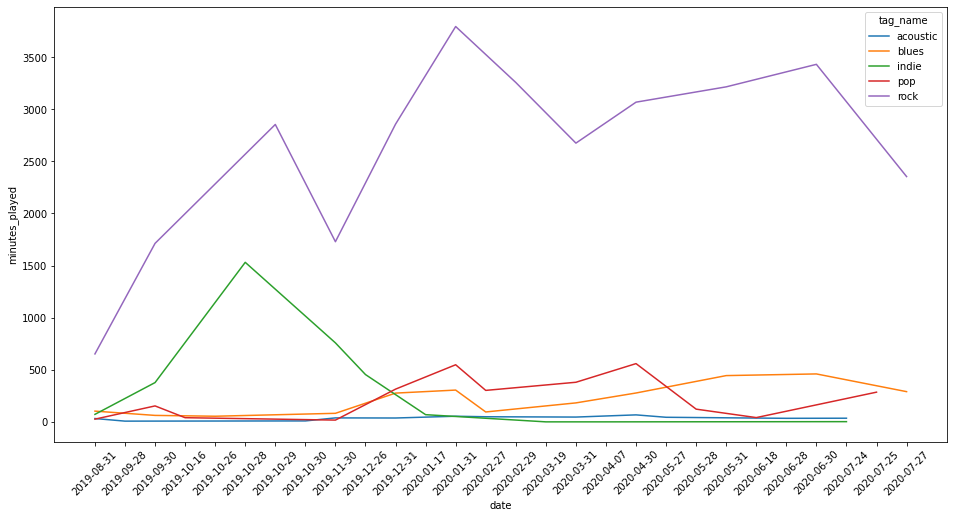

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(data = wanted_tags_1_df, x='date', y='minutes_played', hue='tag_name')
plt.xticks(rotation=45);

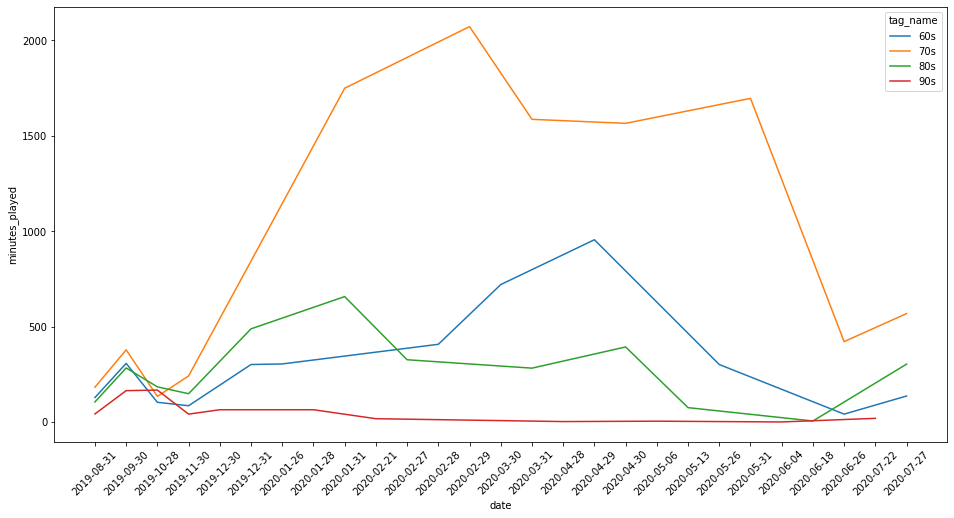

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(data = wanted_tags_2_df, x='date', y='minutes_played', hue='tag_name')
plt.xticks(rotation=45);

# Barchart das bandas mais tocadas

In [ ]:
gb = df.groupby('artistName')

In [ ]:
time_played = gb['msPlayed'].sum().to_frame()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(rc={'figure.figsize':(18,10)})

In [ ]:
most_played_artists = time_played.sort_values('msPlayed', ascending=False)

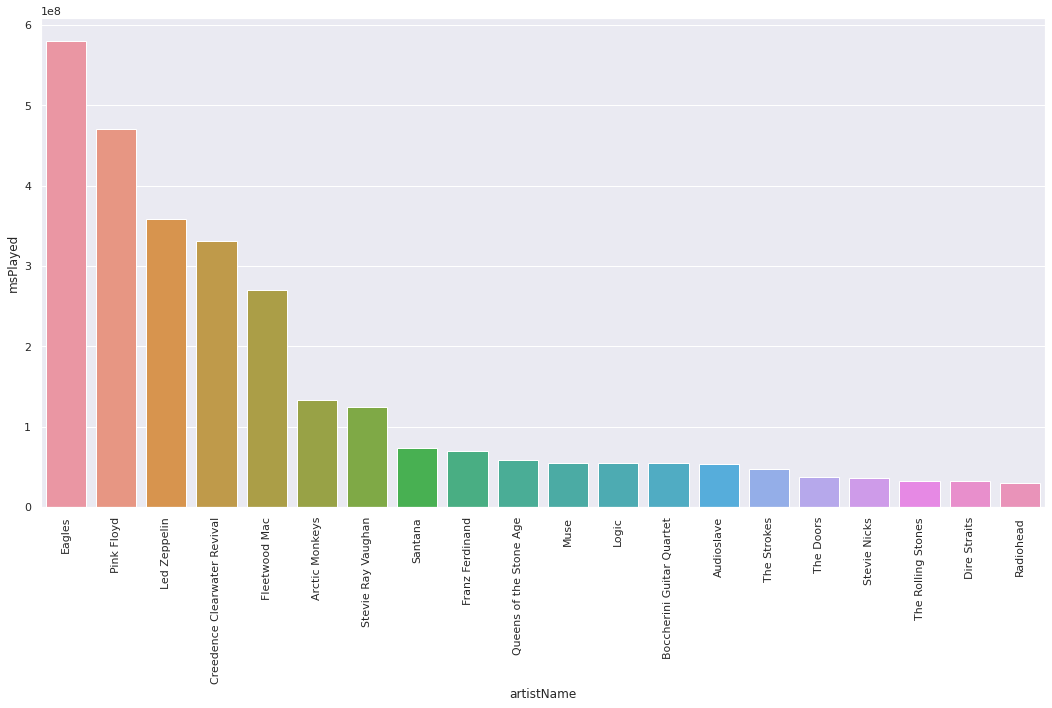

In [ ]:
plt.figure(figsize=(18,9))
graph = sns.barplot(x=most_played_artists.index[:20], y=most_played_artists['msPlayed'][:20])
graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
graph

# Grafico de linha das bandas mais tocadas

In [ ]:
# Criando uma coluna que é só a data (ano-mes-dia)
df['data'] = pd.to_datetime(df['endTime']).dt.date

In [ ]:
top_n_artists = most_played_artists.index[:2]

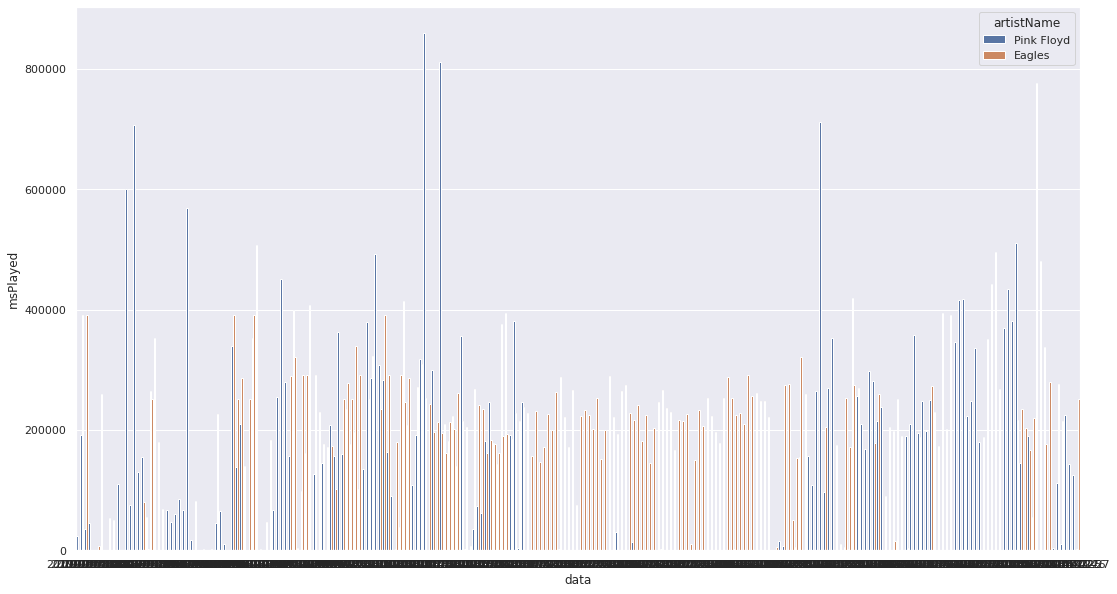

In [ ]:
sns.barplot(x='data', y='msPlayed', hue='artistName', data=df.loc[df['artistName'].isin(top_n_artists)], ci=None)